## Setup variables and install the required packages
We use [ggplot2](http://ggplot2.tidyverse.org/) for the plotting and [ggseqlogo](https://omarwagih.github.io/ggseqlogo/) for the logo plots.

In [110]:
require("pacman", quietly=TRUE)
pacman::p_load('ggseqlogo', 'ggplot2', 'cowplot', 'dplyr', 'reshape2',
  'IRdisplay', 'stringr', 'Matrix', 'tidyr')
sessionInfo()

R version 3.4.0 (2017-04-21)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS Sierra 10.12.6

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] tidyr_0.6.3     Matrix_1.2-10   stringr_1.2.0   bindrcpp_0.2   
 [5] IRdisplay_0.4.4 reshape2_1.4.2  dplyr_0.7.1     cowplot_0.7.0  
 [9] ggplot2_2.2.1   ggseqlogo_0.1   pacman_0.4.6   

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11        compiler_3.4.0      plyr_1.8.4         
 [4] bindr_0.1           tools_3.4.0         digest_0.6.12      
 [7] uuid_0.1-2          lattice_0.20-35     jsonlite_1.5       
[10] evaluate_0.10       tibble_1.3.3        gtable_0.2.0       
[13

Functions for saving / showing images and labeling axes:

In [2]:
saveShowPlot <- function(p, width, height) {
  # save plot with filename of variable name with dots replaced by _, then show
  pngfile <- file.path(sprintf("%s.png", 
    gsub("\\.", "_", deparse(substitute(p)))))
  pdffile <- file.path(sprintf("%s.pdf", 
    gsub("\\.", "_", deparse(substitute(p)))))
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  ggsave(pdffile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile, width=width * 90)
}
    
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

Set up the color-blind palette described [here][1]:

   [1]: http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette

In [3]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                "#0072B2", "#D55E00", "#CC79A7")

## Plot neutralization curves
First, we define a sigmoid neutralization curve function:

In [4]:
#' Sigmoidal neutralization curve
#'
#' Returns fraction infectivity remaining at concentration
#' @param c concentration of antibody
#' @param ic50 IC50 of antibody
#' @alpha the "slope" parameter of the sigmoid
neutcurve <- function(c, ic50, alpha=0.3, percent=TRUE) {
  1 - exp((c - ic50) / alpha) / (1 + (exp((c - ic50) / alpha)))
}

Range of log concentrations over which we will plot:

In [5]:
logcmin <- -4
logcmax <- 1
logcdelta <- 0.01 # interval to calculate values
logc <- seq(from=logcmin, to=logcmax, by=logcdelta)

Now set up function that draws neutralization curves:

In [194]:
#' plot set of neutralization curves and logo plots
#'
#' Returns list of plots
#' @param variants vector of variant names
#' @param ic50s vector of IC50 values
#' @param seqs vector seqs for each variant, first one is wildtype
#' @param conc vector of concentrations at which to draw vertical lines
#' @param colscheme color scheme for logo plot 
plotcurvesandlogo <- function(variants, ic50s, seqs, conc, colscheme) {
  # dataframe giving fraction survive for each antibody at each concentration
  wtseq <- seqs[[1]]
  sites <- seq(1, nchar(wtseq))
  neutdata <- data.frame(logc)  %>%
    merge(data.frame(variant=variants, ic50=ic50s, seq=seqs)) %>%
    merge(data.frame(site=sites)) %>%
    transform(variant=factor(variant, levels=variants)) %>%
    mutate(fracsurvive=neutcurve(logc, ic50), 
      c=10**logc, 
      aa=str_sub(seq, site, site), 
      wt=str_sub(wtseq, site, site))
    
  # neutralization curve plots
  p.neut <- lapply(conc,
    function(concline) {
      ggplot(neutdata, aes(x=c, y=fracsurvive, color=variant)) +
        geom_line(size=0.7) +
        ylab('fraction infectivity') +
        scale_x_log10(expression(paste('antibody concentration (', mu, 'g/ml)')), 
          labels=fancy_scientific) +
        scale_color_manual('', values=cbbPalette) +
        geom_vline(aes(xintercept=concline), color=tail(cbbPalette, n=1),
          linetype='dotted', size=0.8) +
        theme(legend.position='top')
    }
    )
    
  # plot sequence logo
  p.logo <- lapply(conc,
    function (concline) {
      # create matrix with frac surviving data
      mat <- neutdata %>%
        filter(abs(c - concline) == min(abs(c - concline))) %>%
        filter((wt != aa) | (seq == wtseq)) %>%
        dcast(site ~ aa, value.var='fracsurvive', fill=0) %>% 
        as.matrix %>%
        t 
      # make logo plots  
      ggseqlogo(mat, method='custom', col_scheme=colscheme) +
        scale_y_continuous(limits=c(0, 2))
    }  
    )
    
  return(p.logo)
}

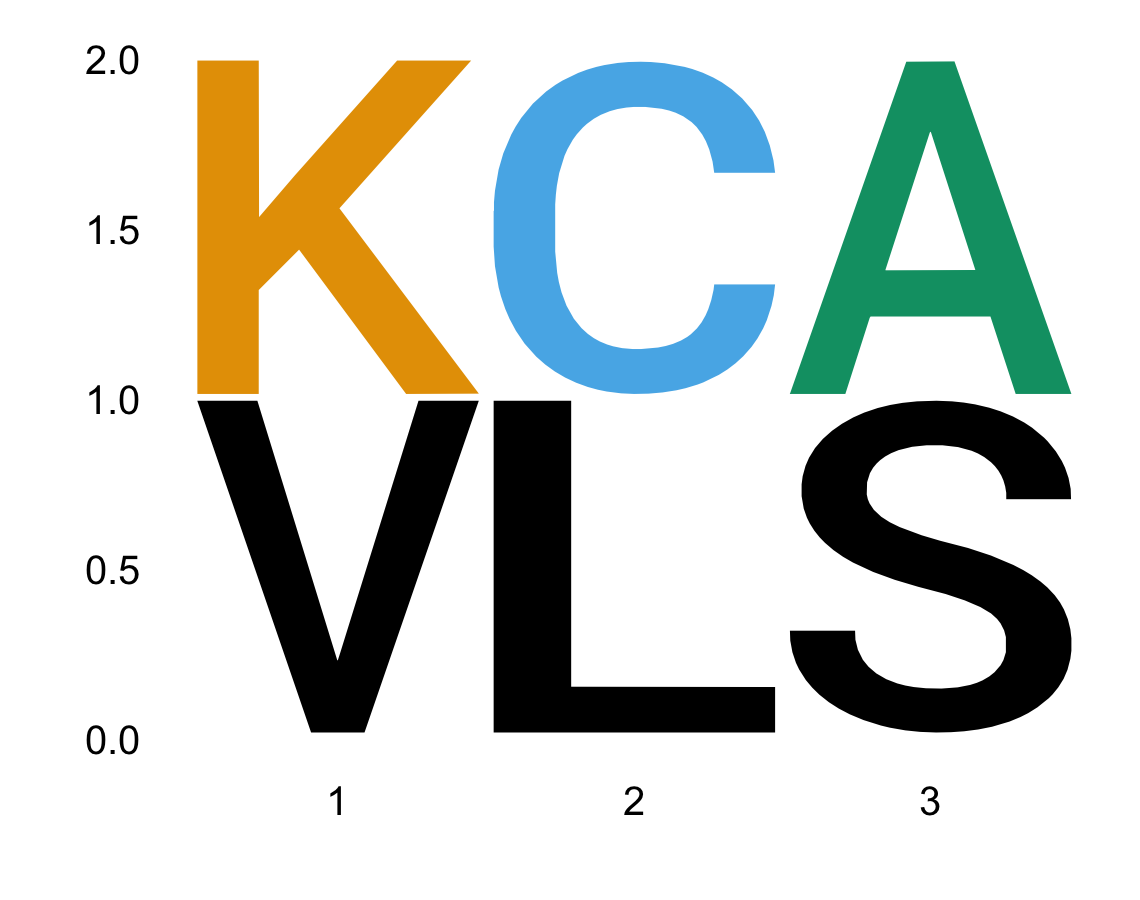

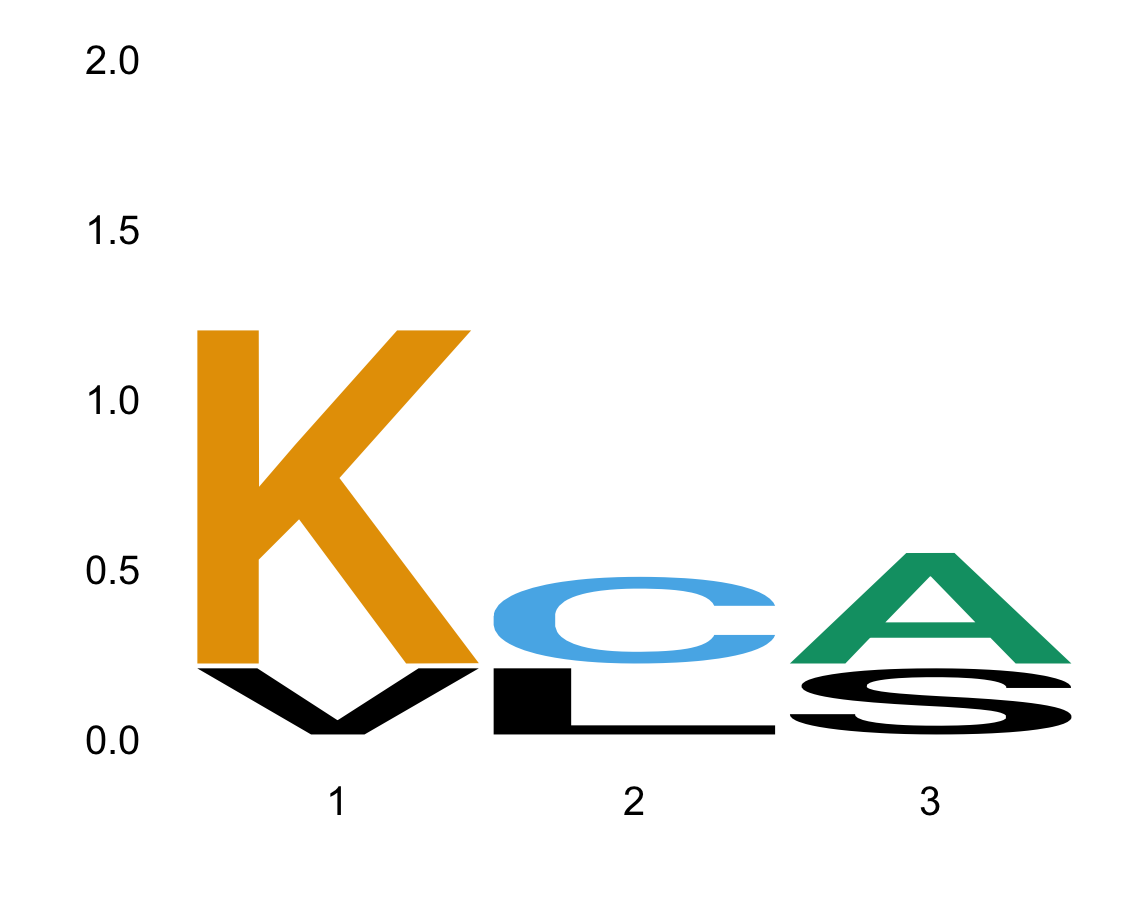

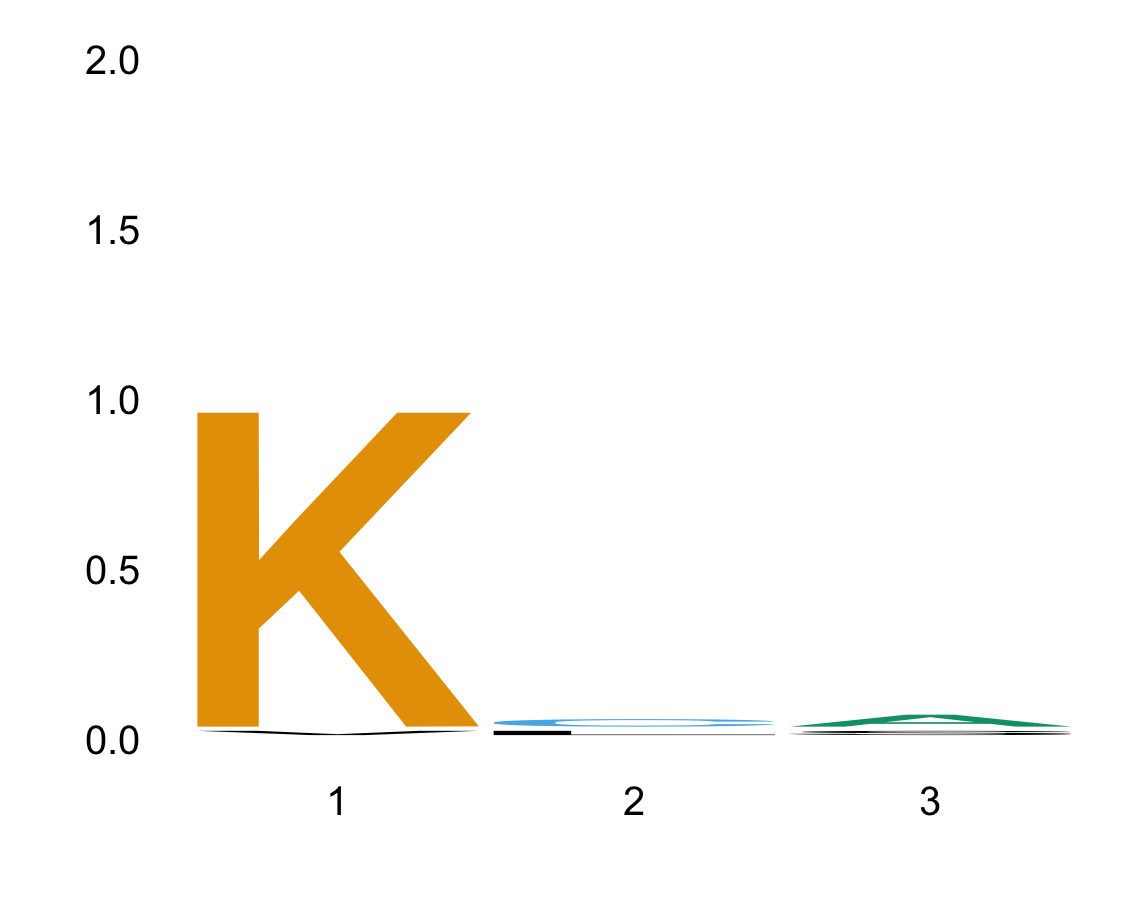

In [195]:
variants <- c('wildtype (VLS)', 'V1K', 'L2C', 'S3A')
seqs <- c('VLS', 'KLS', 'VCS', 'VLA')

# color scheme for logo plots
colscheme <- make_col_scheme(
  chars=c('V', 'L', 'S', 'K', 'C', 'A'),
  cols=c(cbbPalette[[1]], cbbPalette[[1]], cbbPalette[[1]], 
    cbbPalette[[2]], cbbPalette[[3]], cbbPalette[[4]]))

p <- plotcurvesandlogo(
    variants=variants,
    ic50s=c(-2.1, -0.2, -2, -1.9),
    seqs=seqs,
    conc=c(2e-4, 2e-2, 1e-1),
    colscheme=colscheme)

saveShowPlot(p[[1]], width=3.8, height=3)
saveShowPlot(p[[2]], width=3.8, height=3)
saveShowPlot(p[[3]], width=3.8, height=3)